Loading environemnt variables we need to use

In [64]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [34]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

YOUTUBE_VIDEO = "https://www.youtube.com/watch?v=cdiD-9MMpb0"

SETTING UP THE MODEL

In [9]:
from langchain_openai.chat_models import ChatOpenAI

model = ChatOpenAI(openai_api_key = OPENAI_API_KEY, model="gpt-3.5-turbo")

In [10]:
#let's test the model by asking a simple question
model.invoke("Why does the hiring process in tech after covid slowed down?")

AIMessage(content='There are several reasons why the hiring process in tech may have slowed down after COVID-19:\n\n1. Economic uncertainty: Many companies have experienced financial challenges as a result of the pandemic, leading them to be more cautious about hiring new employees.\n\n2. Remote work challenges: The shift to remote work has presented logistical challenges for many companies, including how to effectively onboard and train new employees.\n\n3. Hiring freezes: Some companies have implemented hiring freezes or reduced hiring budgets in response to the economic impact of the pandemic.\n\n4. Focus on current employees: Many companies have shifted their focus to supporting and retaining their current employees during this challenging time, rather than hiring new talent.\n\n5. Uncertain future: The ongoing uncertainty surrounding the pandemic and its long-term impact on the economy has made some companies hesitant to make new hiring decisions.', response_metadata={'token_usage

The output is coming back with AIMessage which is an object, I would like to get a strring back. So, The result from the model is an AIMessage instance containing the answer.
We can extract this answer by chaining the model with an output parser.(supported by LangChain)

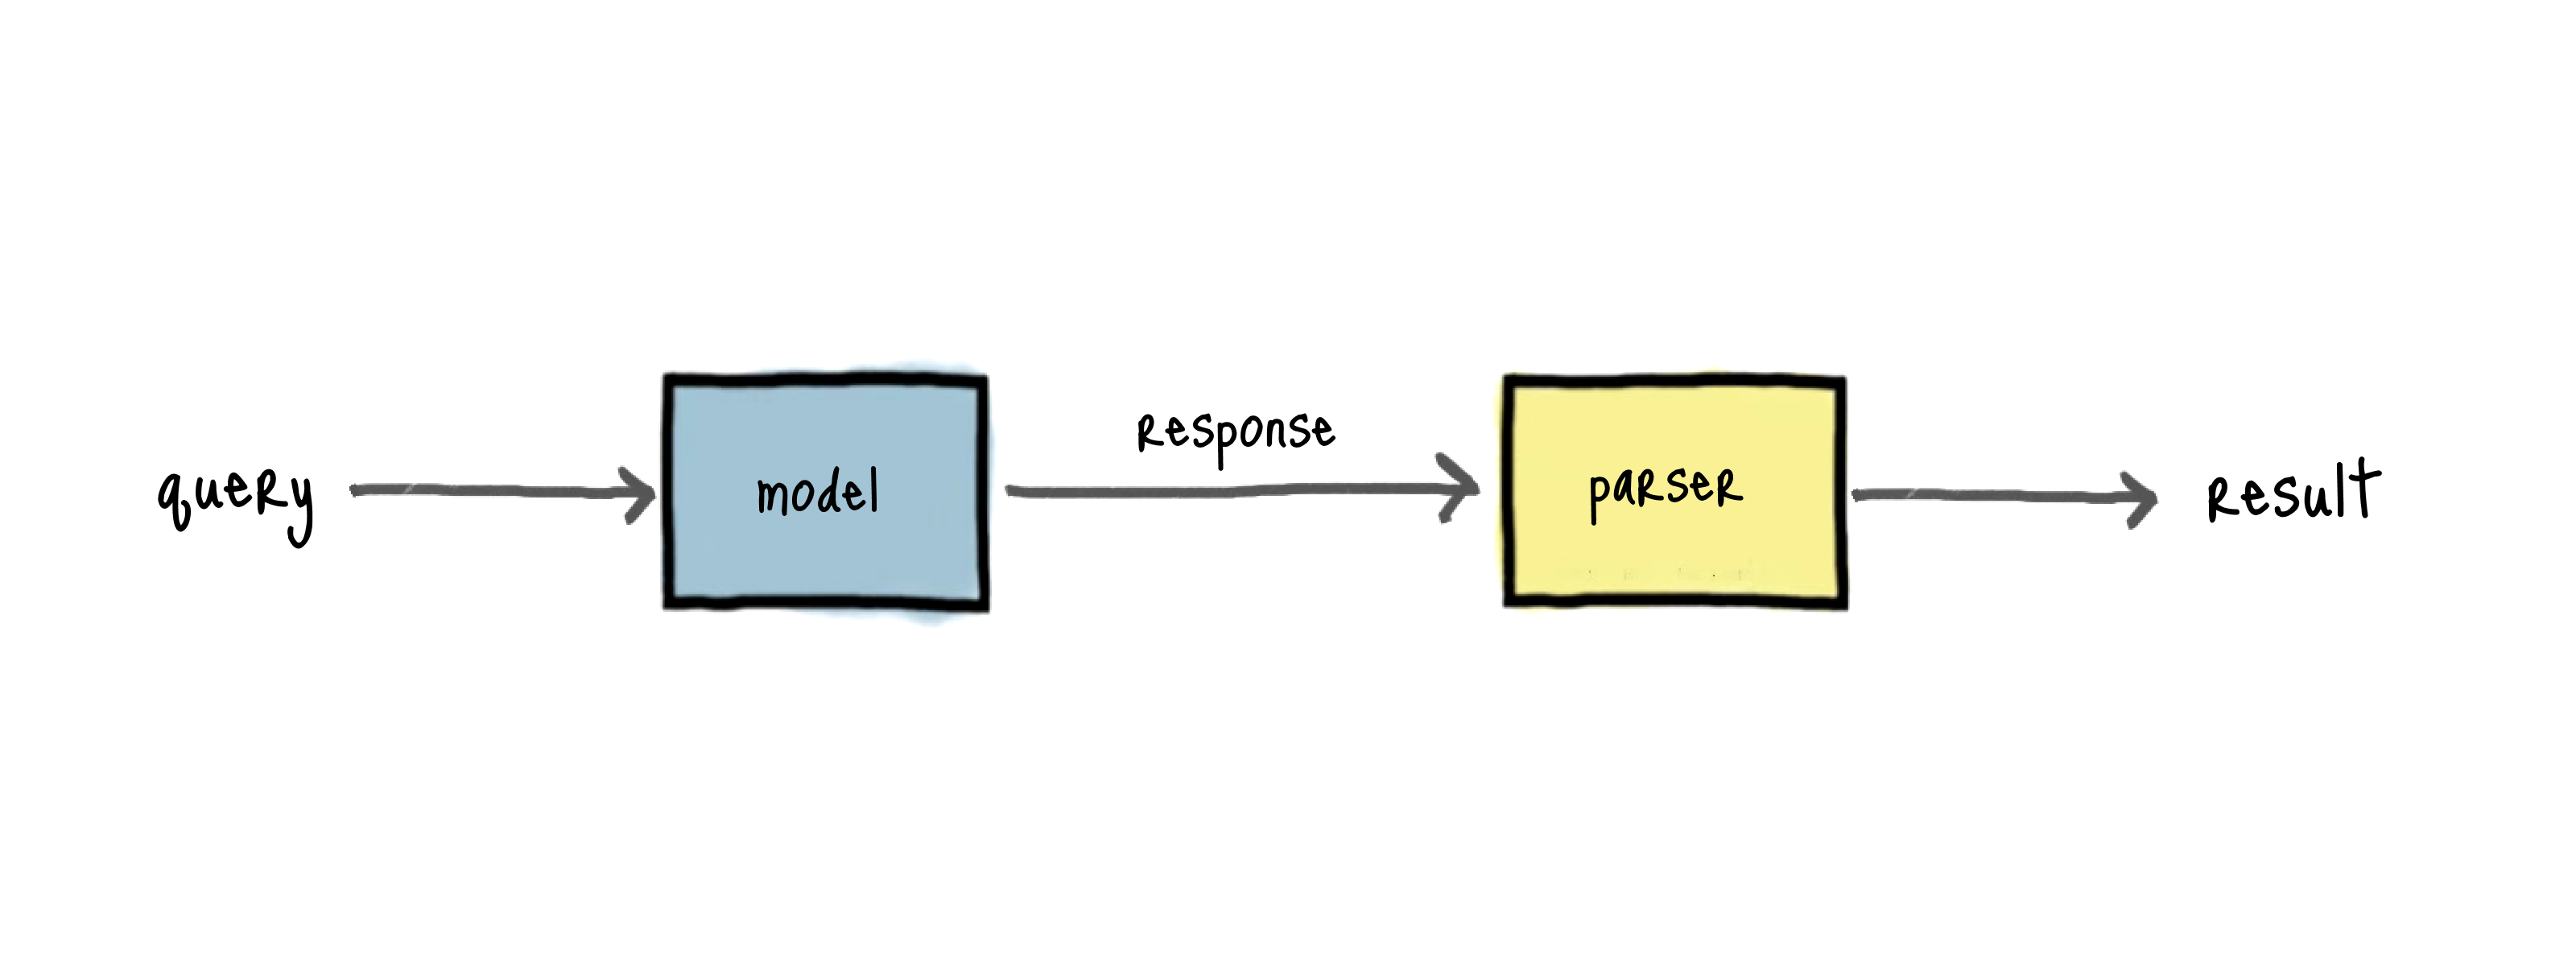

For this example, we'll use a simple StrOutputParser to extract the answer as a string.

In [11]:
from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()

# "|" is chain putting together the model connected to a parser
# model output is input the next component i.e. parser
chain = model | parser

chain.invoke("Why does the hiring process in tech after covid slowed down?")

#AIMessage is scrapped off

'There are several factors that may have contributed to the slowdown in the hiring process in the tech industry after COVID-19:\n\n1. Economic uncertainty: The global pandemic has caused a great deal of economic uncertainty, leading many companies to freeze hiring or reduce their workforce. This has resulted in fewer job opportunities available in the tech sector.\n\n2. Remote work challenges: The shift to remote work has presented challenges for both employers and job seekers. Companies may be hesitant to hire new employees without being able to meet them in person, while job seekers may be more selective about which opportunities they pursue.\n\n3. Budget constraints: Many companies have had to cut costs in response to the economic downturn caused by the pandemic. This has led to hiring freezes or reduced budgets for new hires in the tech industry.\n\n4. Slow decision-making: With many companies adjusting to remote work and dealing with the challenges of the pandemic, decision-making

So we want to send the model a question as well as a transcript, we want the model answer the question from this transcript/context

So we want to combine those two pieces of information in the prompt that we're gonna use on the model 

INTRODUCING PROMPT TEMPLATES
We want to provide the model with some context and the question. PT are a simple way to define and reuse the prompts

In [12]:
from langchain.prompts import ChatPromptTemplate

# we're gonna use this context to inject the transcript from the video
# and going to give the model a question
template = """
Answer the question based on the context below. If you can't 
answer the question, reply "I don't know".


Context: {context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt.format(context="KL Rahul is Indian Batsman", question="Who is Indian Batsaman?") 

'Human: \nAnswer the question based on the context below. If you can\'t \nanswer the question, reply "I don\'t know".\n\n\nContext: KL Rahul is Indian Batsman\n\nQuestion: Who is Indian Batsaman?\n'

We can now chain the prompt with the model and the output parser

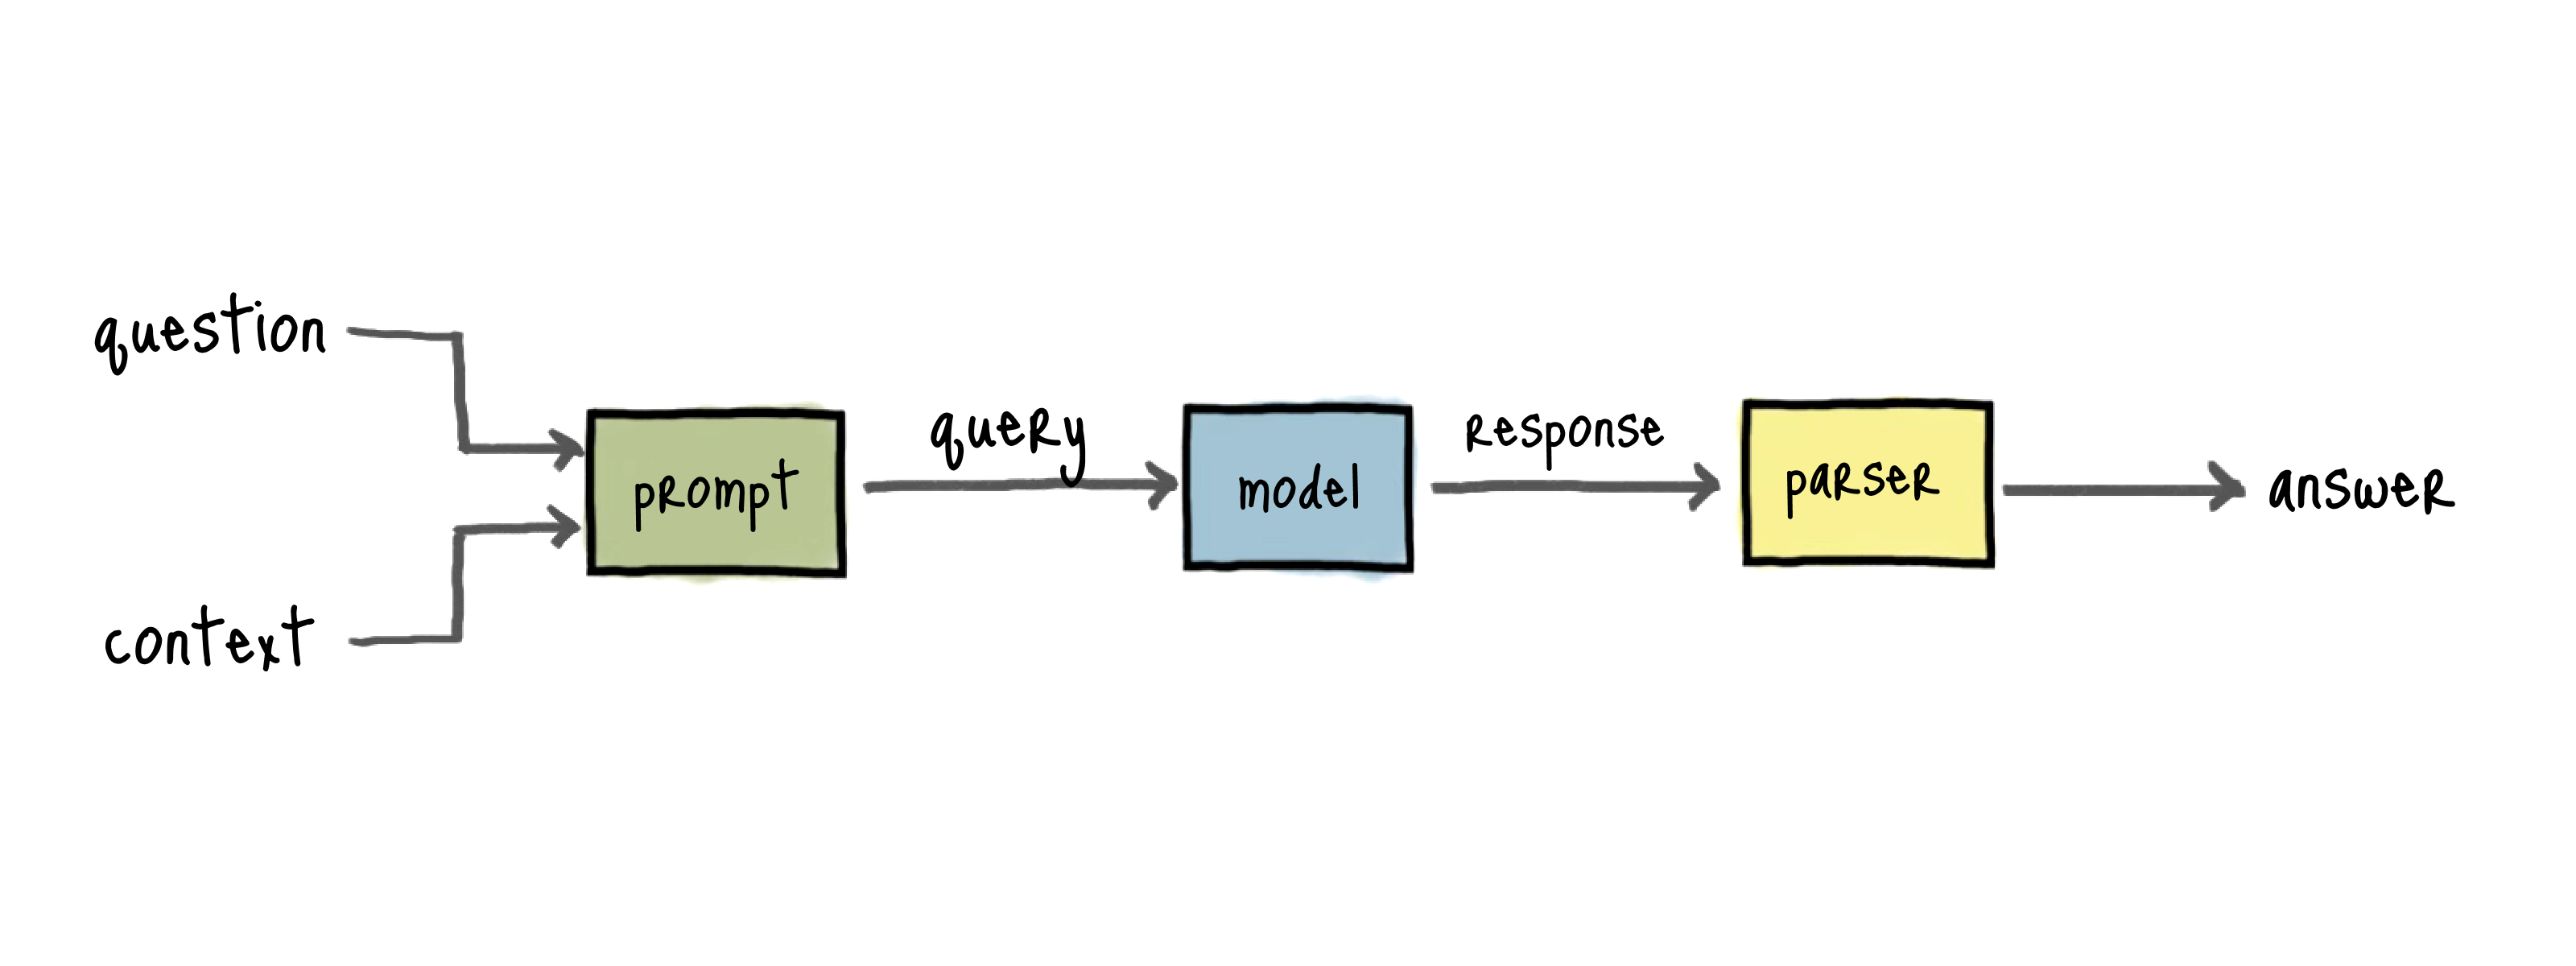

In [13]:
chain = prompt | model | parser

chain.invoke({
    "context": "KL Eahul is Indian Batsman",
    "question": "Who is KL Rahul?"
})

'KL Rahul is an Indian batsman.'

Combining Chains
We can combine different chains to create more complex workflows. For example, let's create a second chain that translates the answer from the first chain into a different language.

Let's start by creating a new prompt template for the translation chain:

In [14]:
translation_prompt = ChatPromptTemplate.from_template(
    "Translate {answer} to {language}"
)


We can now create a new translation chain that combines the result from the first chain with the translation prompt.

Here is what the new workflow looks like:

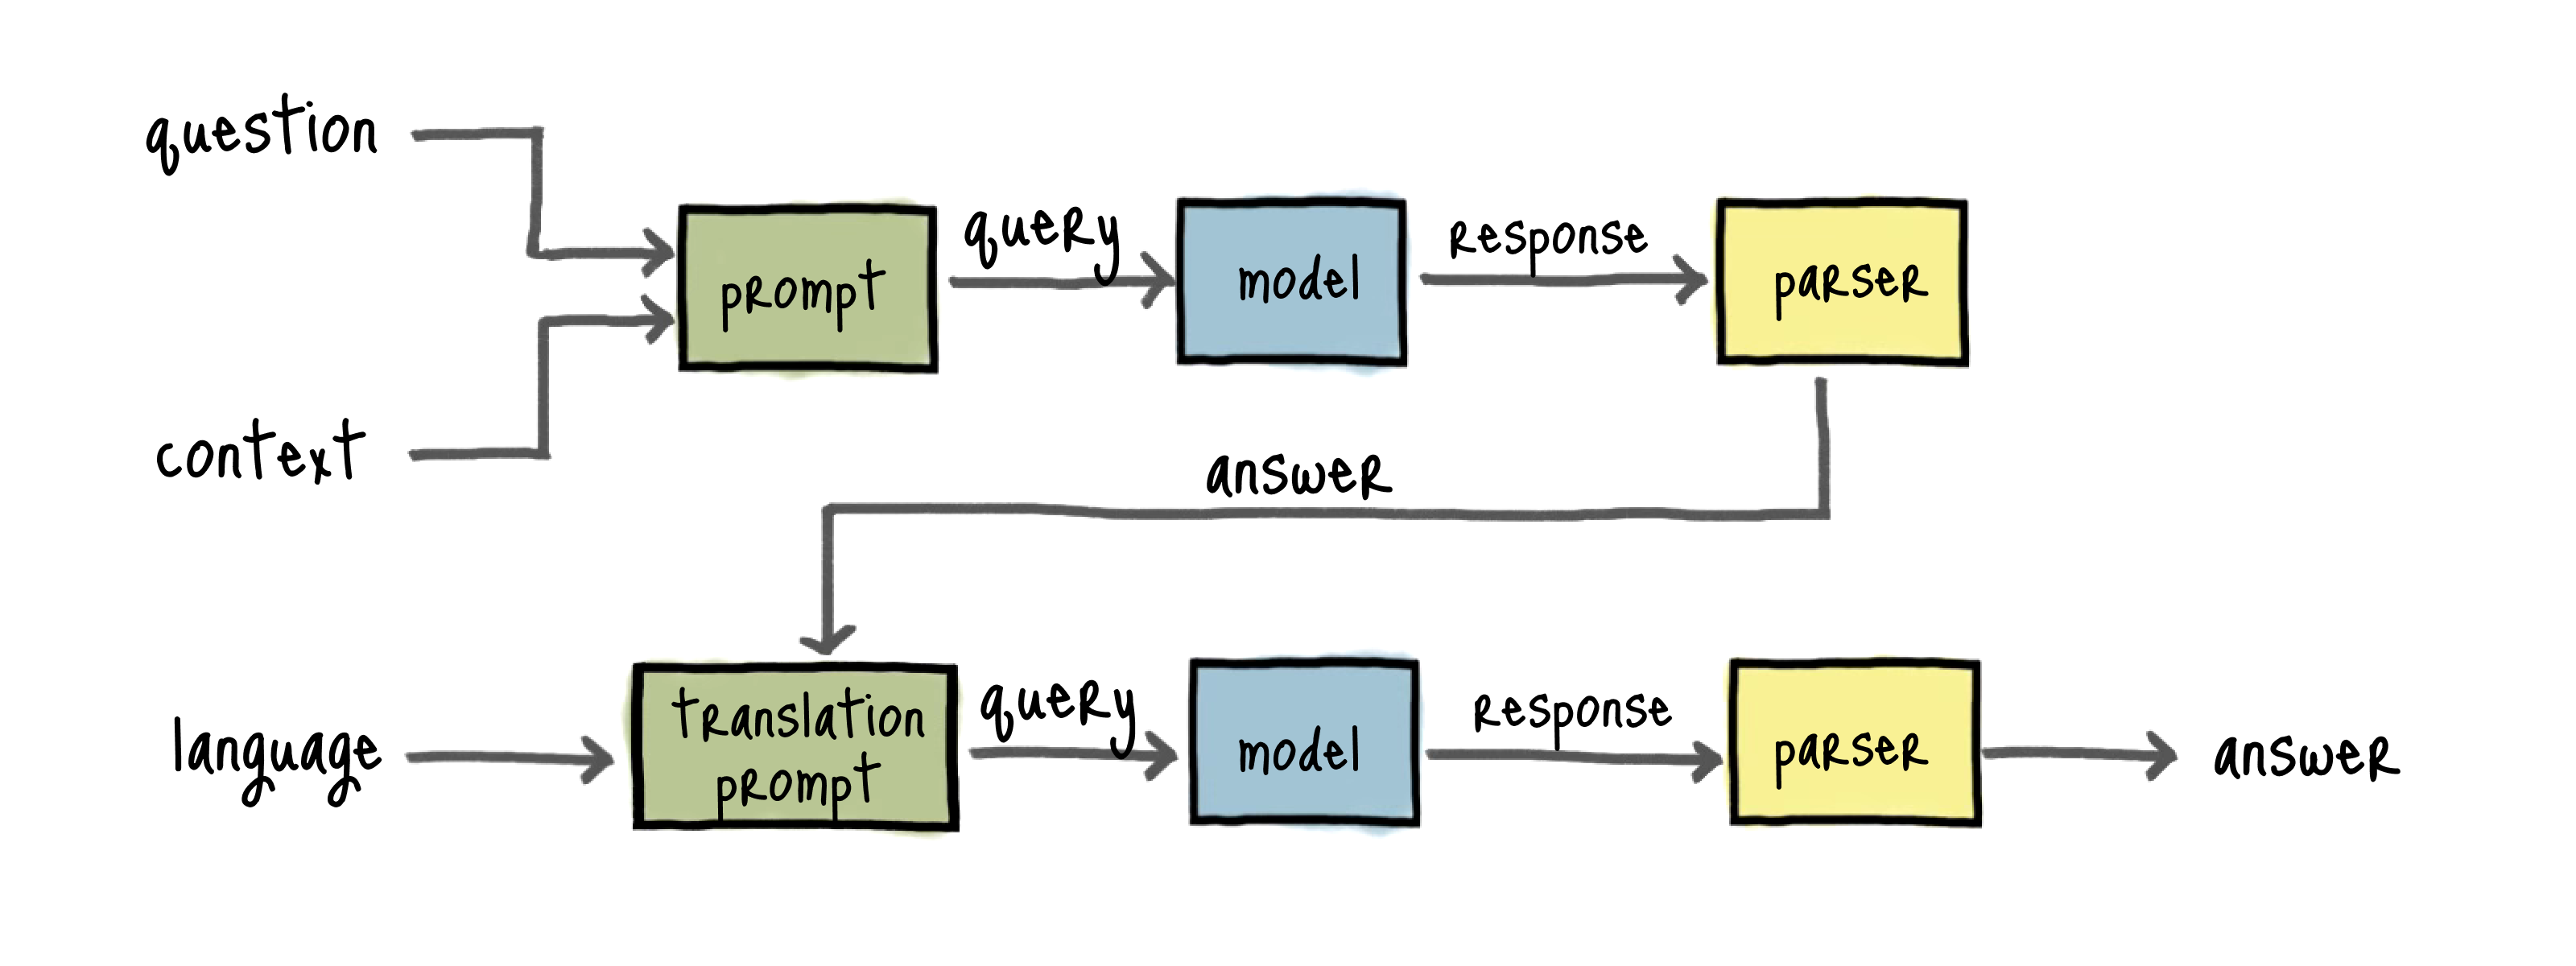


In [24]:
from operator import itemgetter

translation_chain = (
    {"answer": chain, "language": itemgetter("language")} | translation_prompt | model | parser
)

translation_chain.invoke(
    {
        "context": "KL Rahul is Indian Batsman. He is also a wicketkeeper",
        "question": "Who is KL Rahul?",
        "language": "Hindi",
    }
)

'केएल राहुल एक भारतीय क्रिकेटर है जो एक बल्लेबाज भी है और एक विकेटकीपर के रूप में काम करता है।'

Transcribing the YouTube Video
The context we want to send the model comes from a YouTube video. Let's download the video and transcribe it using OpenAI's Whisper.
[Whisper is an automatic speech recognition (ASR) system trained on 680,000 hours of multilingual and multitask supervised data collected from the web.]

In [38]:
import tempfile
import whisper
from pytube import YouTube


# Let's do this only if we haven't created the transcription file yet.
if not os.path.exists("transcription.txt"):
    youtube = YouTube(YOUTUBE_VIDEO)
    audio = youtube.streams.filter(only_audio=True).first()

    # Let's load the base model. This is not the most accurate
    # model but it's fast.
    whisper_model = whisper.load_model("base")

    with tempfile.TemporaryDirectory() as tmpdir:
        file = audio.download(output_path=tmpdir)
        transcription = whisper_model.transcribe(file, fp16=False)["text"].strip()

        with open("transcription.txt", "w") as file:
            file.write(transcription)

Let's read the transcription and display the first few characters to ensure everything works as expected.

In [39]:

with open("transcription.txt") as file:
    transcription = file.read()

transcription[:100]

"I think it's possible that physics has exploits and we should be trying to find them. arranging some"

Using the entire transcription as context

If we try to invoke the chain using the transcription as context, the model will return an error because the context is too long.

Large Language Models support limitted context sizes. The video we are using is too long for the model to handle, so we need to find a different solution.

In [40]:

try:
    chain.invoke({
        "context": transcription,
        "question": "Is reading papers a good idea?"
    })
except Exception as e:
    print(e)

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': '\nAnswer the question based on the context below. If you can\'t \nanswer the question, reply "I don\'t know".\n\n\nContext: I think it\'s possible that physics has exploits and we should be trying to find them. arranging some kind of a crazy quantum mechanical system that somehow gives you buffer overflow, somehow gives you a rounding error in the floating point. Synthetic intelligences are kind of like the next stage of development. And I don\'t know where it leads to. Like at some point, I suspect the universe is some kind of a puzzle. These synthetic AIs will uncover that puzzle and solve it. The following is a conversation with Andre Kappathi, previously the director of AI at Tesla. And before that, at OpenAI and Stanford, he is one of the greatest scientist engineers and educators in the history of artificial intelligence. This is the Lex

Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 47050 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}


In [42]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader("transcription.txt")
text_documents = loader.load()
text_documents

[Document(metadata={'source': 'transcription.txt'}, page_content="I think it's possible that physics has exploits and we should be trying to find them. arranging some kind of a crazy quantum mechanical system that somehow gives you buffer overflow, somehow gives you a rounding error in the floating point. Synthetic intelligences are kind of like the next stage of development. And I don't know where it leads to. Like at some point, I suspect the universe is some kind of a puzzle. These synthetic AIs will uncover that puzzle and solve it. The following is a conversation with Andre Kappathi, previously the director of AI at Tesla. And before that, at OpenAI and Stanford, he is one of the greatest scientist engineers and educators in the history of artificial intelligence. This is the Lex Friedman podcast to support it. Please check out our sponsors and now to your friends. Here's Andre Kappathi. What is a neural network? And what does it seem to do such a surprisingly good job of learning

There are many different ways to split a document. For this example, we'll use a simple splitter that splits the document into chunks of a fixed size. Check Text Splitters for more information about different approaches to splitting documents.

For illustration purposes, let's split the transcription into chunks of 100 characters with an overlap of 20 characters and display the first few chunks:

In [43]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=20)
text_splitter.split_documents(text_documents)[:5]

[Document(metadata={'source': 'transcription.txt'}, page_content="I think it's possible that physics has exploits and we should be trying to find them. arranging some"),
 Document(metadata={'source': 'transcription.txt'}, page_content='arranging some kind of a crazy quantum mechanical system that somehow gives you buffer overflow,'),
 Document(metadata={'source': 'transcription.txt'}, page_content='buffer overflow, somehow gives you a rounding error in the floating point. Synthetic intelligences'),
 Document(metadata={'source': 'transcription.txt'}, page_content="intelligences are kind of like the next stage of development. And I don't know where it leads to."),
 Document(metadata={'source': 'transcription.txt'}, page_content='where it leads to. Like at some point, I suspect the universe is some kind of a puzzle. These')]

For our specific application, let's use 1000 characters instead:

In [44]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
documents = text_splitter.split_documents(text_documents)

Finding the relevant chunks

Given a particular question, we need to find the relevant chunks from the transcription to send to the model. Here is where the idea of embeddings comes into play.

An embedding is a mathematical representation of the semantic meaning of a word, sentence, or document. It's a projection of a concept in a high-dimensional space. Embeddings have a simple characteristic: The projection of related concepts will be close to each other, while concepts with different meanings will lie far away. You can use the Cohere's Embed Playground to visualize embeddings in two dimensions.

To provide with the most relevant chunks, we can use the embeddings of the question and the chunks of the transcription to compute the similarity between them. We can then select the chunks with the highest similarity to the question and use them as the context for the model:

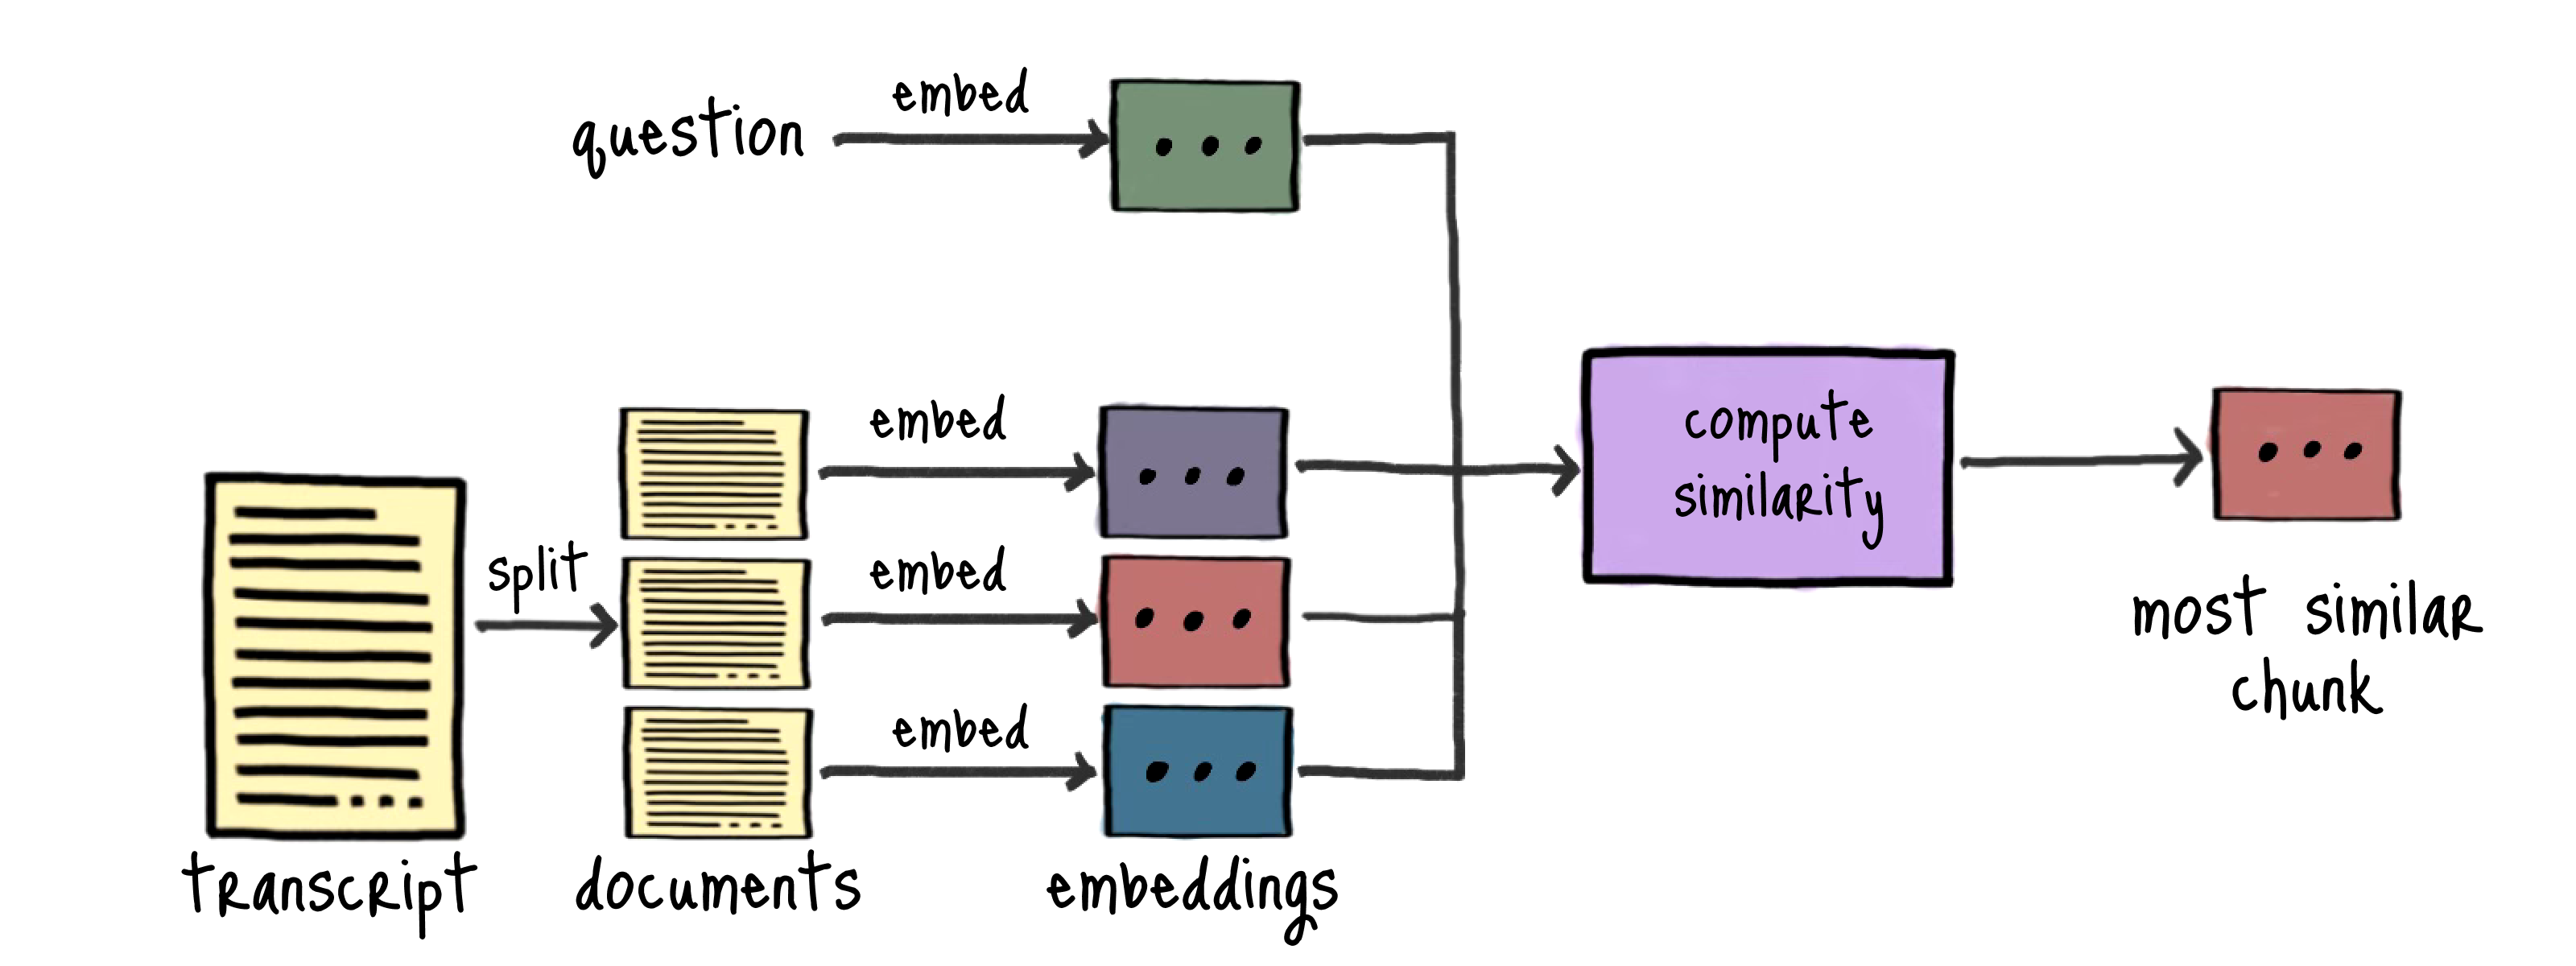

Let's generate embeddings for an arbitrary query:

In [45]:

from langchain_openai.embeddings import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()
embedded_query = embeddings.embed_query("Who is KL Rahul?")

print(f"Embedding length: {len(embedded_query)}")
print(embedded_query[:10])

DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='d:\\RAG\\env\\Lib\\site-packages\\certifi\\cacert.pem'
DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='d:\\RAG\\env\\Lib\\site-packages\\certifi\\cacert.pem'
DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x000001DB787400E0>, 'json_data': {'input': [[15546, 374, 68810, 86236, 30]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
DEBUG:openai._base_client:Sending HTTP Request: POST https://api.openai.com/v1/embeddings
DEBUG:httpcore.connection:connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
DEBUG:httpcore.connection:connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001DB1B2B9A50>
D

Embedding length: 1536
[0.0015911741647869349, 0.0060804421082139015, 0.006547665689140558, 0.014728980138897896, -0.042527154088020325, 0.02177327498793602, -0.026386700570583344, -0.0032444270327687263, -0.02643897756934166, -0.014180074445903301]



To illustrate how embeddings work, let's first generate the embeddings for two different sentences:

In [46]:

sentence1 = embeddings.embed_query("KL Rahul is Indian Batsman")
sentence2 = embeddings.embed_query("Suneel Chhetry is Footballer")

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x000001DB1B89E840>, 'json_data': {'input': [[54083, 86236, 374, 7904, 426, 1900, 1543]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
DEBUG:openai._base_client:Sending HTTP Request: POST https://api.openai.com/v1/embeddings
DEBUG:httpcore.connection:close.started
DEBUG:httpcore.connection:close.complete
DEBUG:httpcore.connection:connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
DEBUG:httpcore.connection:connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001DB1B249E50>
DEBUG:httpcore.connection:start_tls.started ssl_context=<ssl.SSLContext object at 0x000001DB1B8990A0> server_hostname='api.openai.com' timeout=None
DEBUG:httpcore.connection:start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x0000

We can now compute the similarity between the query and each of the two sentences. The closer the embeddings are, the more similar the sentences will be.

We can use Cosine Similarity to calculate the similarity between the query and each of the sentences:

In [47]:

from sklearn.metrics.pairwise import cosine_similarity

query_sentence1_similarity = cosine_similarity([embedded_query], [sentence1])[0][0]
query_sentence2_similarity = cosine_similarity([embedded_query], [sentence2])[0][0]

query_sentence1_similarity, query_sentence2_similarity

(0.9058680977655781, 0.7868302222686756)

Setting up a Vector Store

We need an efficient way to store document chunks, their embeddings, and perform similarity searches at scale. To do this, we'll use a vector store.

A vector store is a database of embeddings that specializes in fast similarity searches.

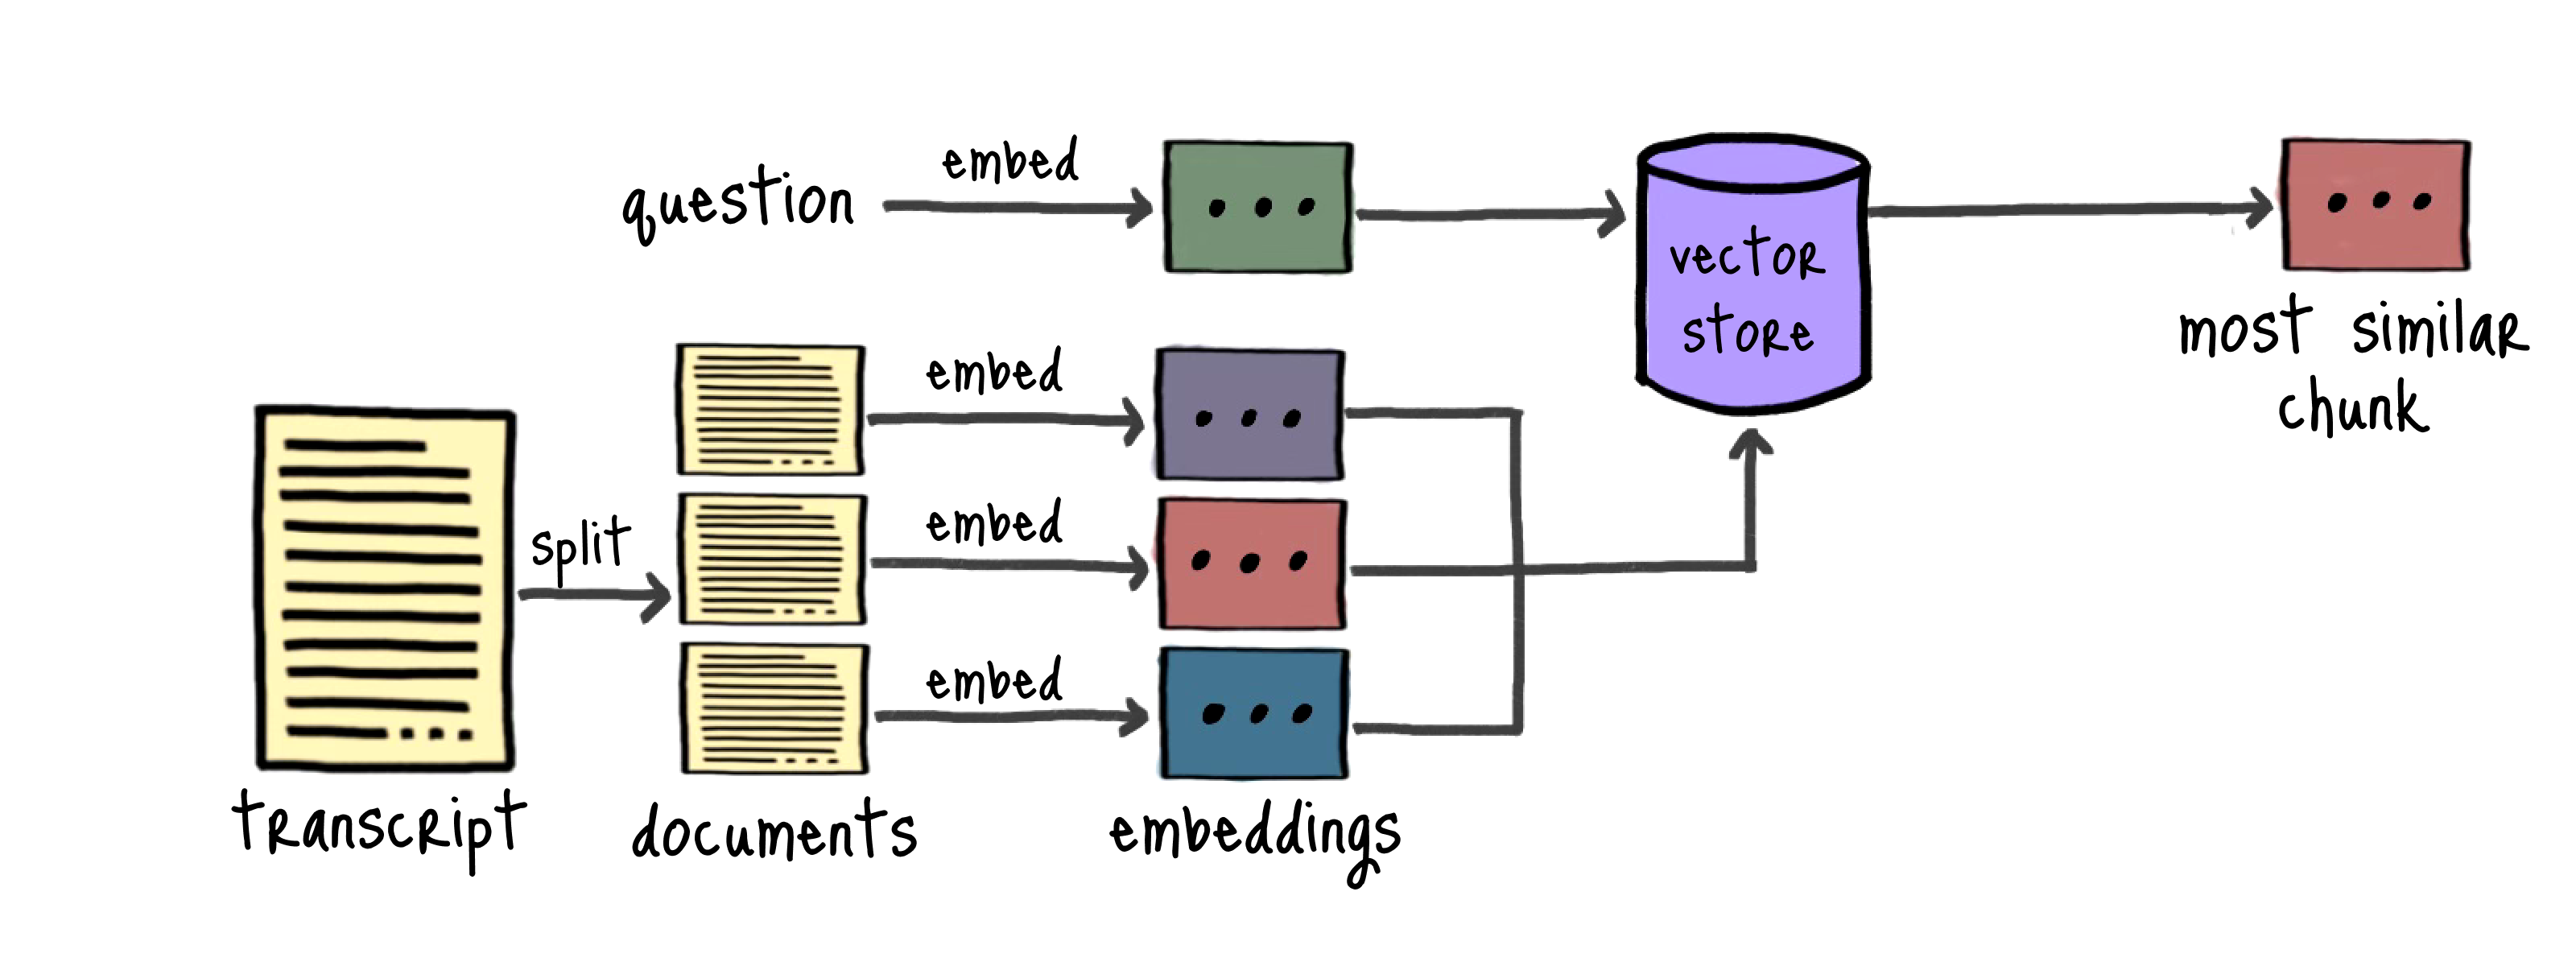

To understand how a vector store works, let's create one in memory and add a few embeddings to it:

In [49]:
from langchain_community.vectorstores import DocArrayInMemorySearch

vectorstore1 = DocArrayInMemorySearch.from_texts(
    [
        "KL Rahul is Indian Batsman",
        "Lakshya Sen play a very good badminton",
        "Fans say Thala for a Reason for MS Dhoni",
        "India lost WC 2019 due to MS Dhoni",
        "Virat Kohli has 80 centuries",
        "Himanshu has two brothers",
    ],
    embedding=embeddings,
)

INFO - docarray - DB config created
INFO:docarray:DB config created
INFO - docarray - Runtime config created
INFO:docarray:Runtime config created
INFO - docarray - No docs or index file provided. Initializing empty InMemoryExactNNIndex.
INFO:docarray:No docs or index file provided. Initializing empty InMemoryExactNNIndex.
DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x000001DB380F2520>, 'json_data': {'input': [[54083, 86236, 374, 7904, 426, 1900, 1543], [43, 587, 939, 7911, 5476, 1514, 264, 1633, 1695, 3958, 76, 7454], [76887, 2019, 666, 6181, 369, 264, 27857, 369, 10504, 44327, 21446], [34648, 5675, 37746, 220, 679, 24, 4245, 311, 10504, 44327, 21446], [50135, 266, 34975, 747, 706, 220, 1490, 24552], [39, 318, 598, 17156, 706, 1403, 20820]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
DEBUG:openai._base_client:Sending HTTP Request: POST https://api.o


We can now query the vector store to find the most similar embeddings to a given query:

In [52]:
vectorstore1.similarity_search_with_score(query="Who is MS Dhoni?", k=6)

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x000001DB1B89E5C0>, 'json_data': {'input': [[15546, 374, 10504, 44327, 21446, 30]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
DEBUG:openai._base_client:Sending HTTP Request: POST https://api.openai.com/v1/embeddings
DEBUG:httpcore.connection:close.started
DEBUG:httpcore.connection:close.complete
DEBUG:httpcore.connection:connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
DEBUG:httpcore.connection:connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001DB1BB2E650>
DEBUG:httpcore.connection:start_tls.started ssl_context=<ssl.SSLContext object at 0x000001DB1B8990A0> server_hostname='api.openai.com' timeout=None
DEBUG:httpcore.connection:start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001DB1

[(Document(page_content='India lost WC 2019 due to MS Dhoni'),
  0.8656656800593647),
 (Document(page_content='Fans say Thala for a Reason for MS Dhoni'),
  0.8457734446220545),
 (Document(page_content='KL Rahul is Indian Batsman'), 0.8137063903659549),
 (Document(page_content='Virat Kohli has 80 centuries'), 0.8010205944630729),
 (Document(page_content='Lakshya Sen play a very good badminton'),
  0.7994371639351096),
 (Document(page_content='Himanshu has two brothers'), 0.764988664476012)]


Connecting the vector store to the chain

We can use the vector store to find the most relevant chunks from the transcription to send to the model. Here is how we can connect the vector store to the chain:

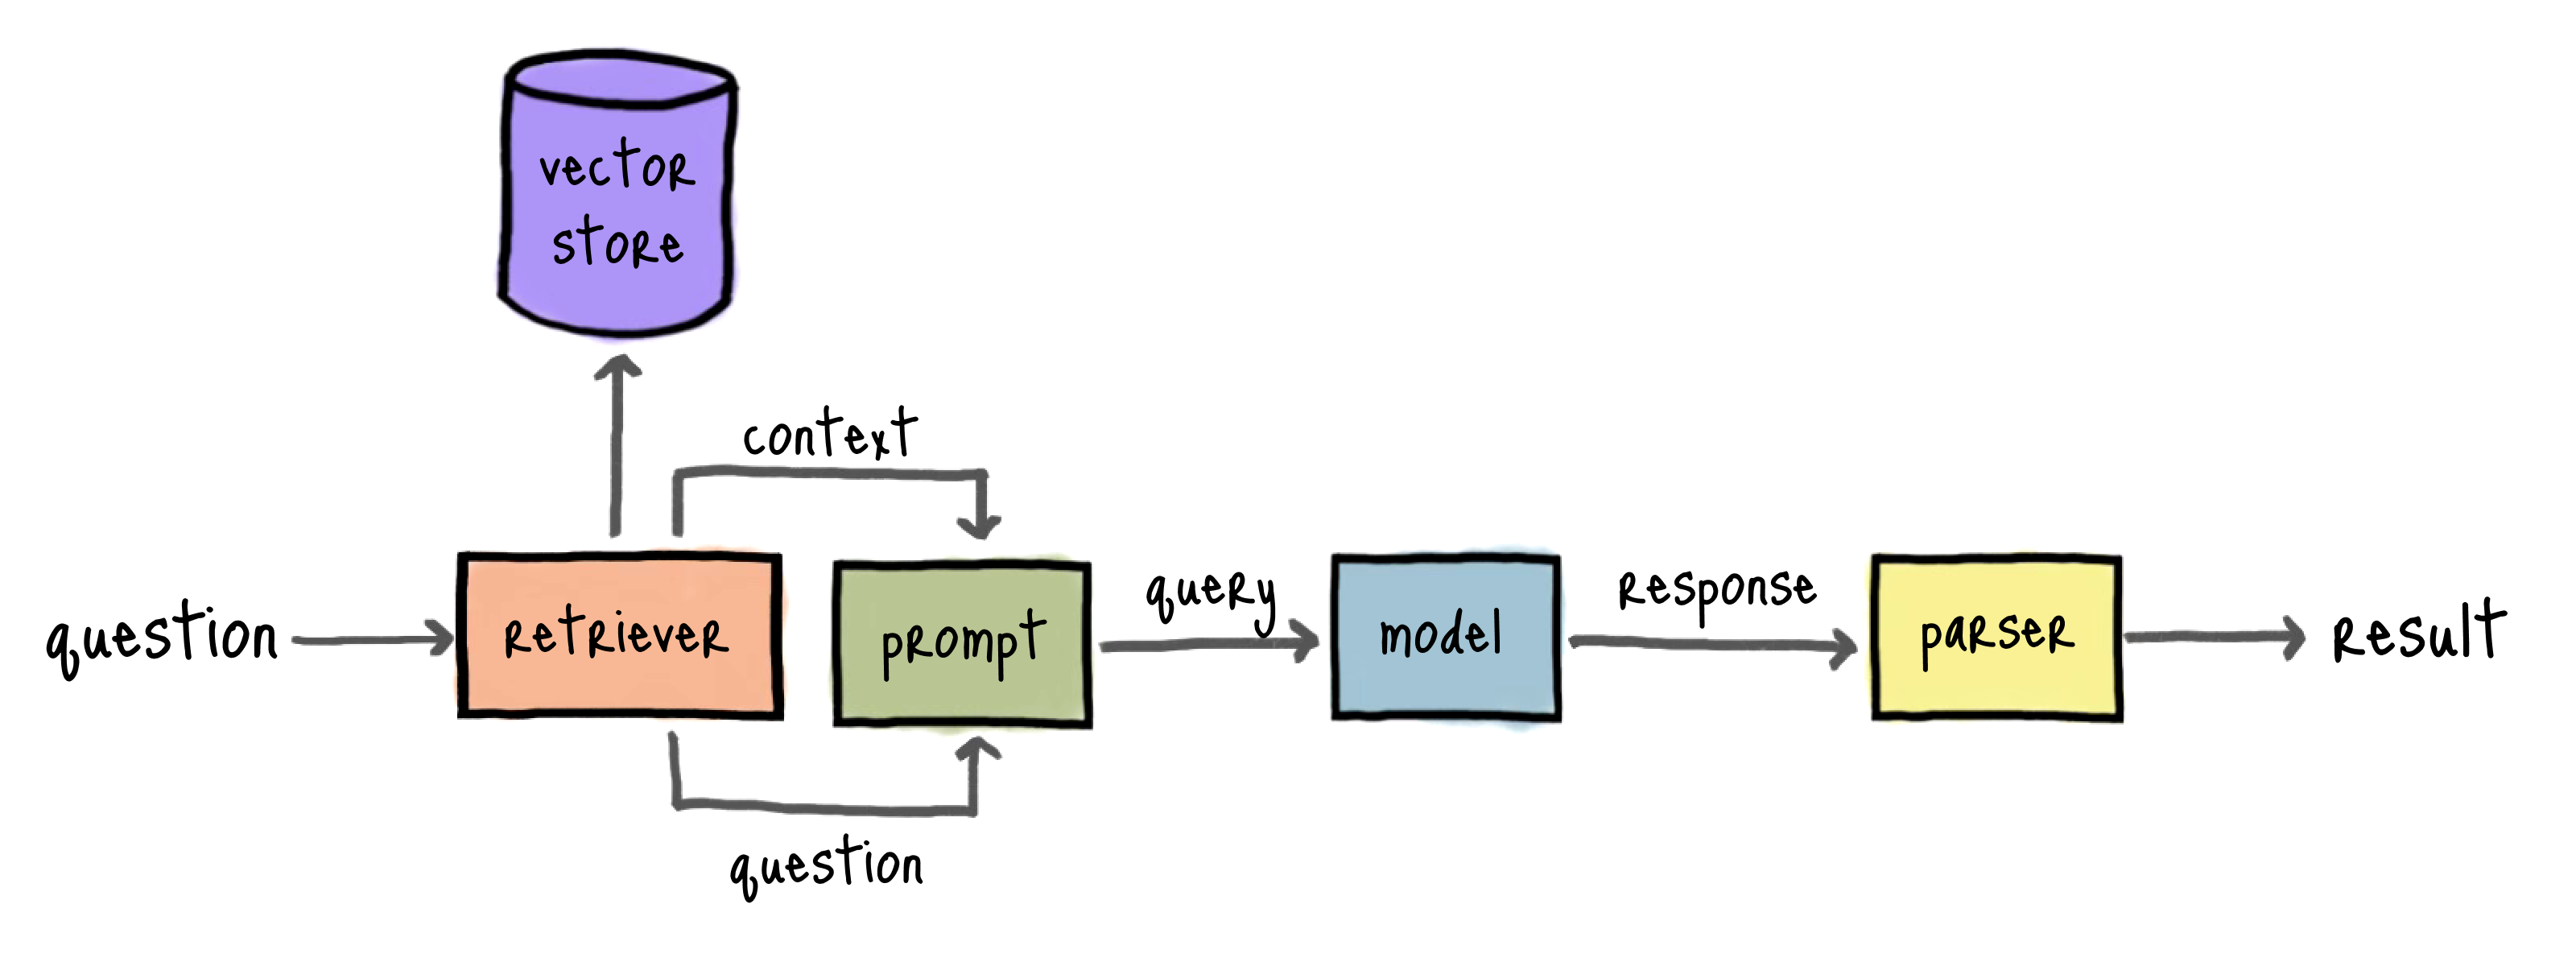



We need to configure a Retriever. The retriever will run a similarity search in the vector store and return the most similar documents back to the next step in the chain.

We can get a retriever directly from the vector store we created before:

In [53]:

retriever1 = vectorstore1.as_retriever()
retriever1.invoke("Who is MS Dhoni?")

DEBUG:langchain_core.vectorstores.base:The embeddings property has not been implemented for DocArrayInMemorySearch
DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x000001DB1B35CA40>, 'json_data': {'input': [[15546, 374, 10504, 44327, 21446, 30]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
DEBUG:openai._base_client:Sending HTTP Request: POST https://api.openai.com/v1/embeddings
DEBUG:httpcore.connection:close.started
DEBUG:httpcore.connection:close.complete
DEBUG:httpcore.connection:connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
DEBUG:httpcore.connection:connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001DB1C1E4290>
DEBUG:httpcore.connection:start_tls.started ssl_context=<ssl.SSLContext object at 0x000001DB1B8990A0> server_hostname='api.openai.com' timeout=None


[Document(page_content='India lost WC 2019 due to MS Dhoni'),
 Document(page_content='Fans say Thala for a Reason for MS Dhoni'),
 Document(page_content='KL Rahul is Indian Batsman'),
 Document(page_content='Virat Kohli has 80 centuries')]

**Our prompt expects two parameters, "context" and "question." We can use the retriever to find the chunks we'll use as the context to answer the question.**

We can create a map with the two inputs by using the *RunnableParallel* and *RunnablePassthrough* classes. This will allow us to pass the context and question to the prompt as a map with the keys "context" and "question.

In [55]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

setup = RunnableParallel(context=retriever1, question=RunnablePassthrough())
setup.invoke("How many siblings Himanshu have?")

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x000001DB380F3240>, 'json_data': {'input': [[4438, 1690, 37783, 21058, 598, 17156, 617, 30]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
DEBUG:openai._base_client:Sending HTTP Request: POST https://api.openai.com/v1/embeddings
DEBUG:httpcore.connection:close.started
DEBUG:httpcore.connection:close.complete
DEBUG:httpcore.connection:connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
DEBUG:httpcore.connection:connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001DB1C0D1E10>
DEBUG:httpcore.connection:start_tls.started ssl_context=<ssl.SSLContext object at 0x000001DB1B8990A0> server_hostname='api.openai.com' timeout=None
DEBUG:httpcore.connection:start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0

{'context': [Document(page_content='Himanshu has two brothers'),
  Document(page_content='Virat Kohli has 80 centuries'),
  Document(page_content='Lakshya Sen play a very good badminton'),
  Document(page_content='KL Rahul is Indian Batsman')],
 'question': 'How many siblings Himanshu have?'}


Let's now add the setup map to the chain and run it:

In [58]:

chain = setup | prompt | model | parser
chain.invoke("Who is KL Rahul?")

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x000001DB380F3380>, 'json_data': {'input': [[15546, 374, 68810, 86236, 30]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
DEBUG:openai._base_client:Sending HTTP Request: POST https://api.openai.com/v1/embeddings
DEBUG:httpcore.connection:close.started
DEBUG:httpcore.connection:close.complete
DEBUG:httpcore.connection:connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
DEBUG:httpcore.connection:connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001DB381A7050>
DEBUG:httpcore.connection:start_tls.started ssl_context=<ssl.SSLContext object at 0x000001DB1B8990A0> server_hostname='api.openai.com' timeout=None
DEBUG:httpcore.connection:start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001DB1B47DF10

'KL Rahul is an Indian Batsman.'


Let's invoke the chain using another example:

In [59]:

chain.invoke("What do you know about Virat Kohli?")


DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x000001DB380F2FC0>, 'json_data': {'input': [[3923, 656, 499, 1440, 922, 9734, 266, 34975, 747, 30]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
DEBUG:openai._base_client:Sending HTTP Request: POST https://api.openai.com/v1/embeddings
DEBUG:httpcore.connection:close.started
DEBUG:httpcore.connection:close.complete
DEBUG:httpcore.connection:connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
DEBUG:httpcore.connection:connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001DB380C95D0>
DEBUG:httpcore.connection:start_tls.started ssl_context=<ssl.SSLContext object at 0x000001DB1B8990A0> server_hostname='api.openai.com' timeout=None
DEBUG:httpcore.connection:start_tls.complete return_value=<httpcore._backends.sync.SyncStream obje

'Virat Kohli has 80 centuries.'

Loading transcription into the vector store

We initialized the vector store with a few random strings. Let's create a new vector store using the chunks from the video transcription.

In [60]:

vectorstore2 = DocArrayInMemorySearch.from_documents(documents, embeddings)

INFO - docarray - DB config created
INFO:docarray:DB config created
INFO - docarray - Runtime config created
INFO:docarray:Runtime config created
INFO - docarray - No docs or index file provided. Initializing empty InMemoryExactNNIndex.
INFO:docarray:No docs or index file provided. Initializing empty InMemoryExactNNIndex.
DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x000001DB380F2D40>, 'json_data': {'input': [[40, 1781, 433, 596, 3284, 430, 22027, 706, 63488, 323, 584, 1288, 387, 4560, 311, 1505, 1124, 13, 77218, 1063, 3169, 315, 264, 14599, 31228, 22936, 1887, 430, 17354, 6835, 499, 4240, 16891, 11, 17354, 6835, 499, 264, 52662, 1493, 304, 279, 19596, 1486, 13, 75928, 60538, 2436, 527, 3169, 315, 1093, 279, 1828, 6566, 315, 4500, 13, 1628, 358, 1541, 956, 1440, 1405, 433, 11767, 311, 13, 9086, 520, 1063, 1486, 11, 358, 15562, 279, 15861, 374, 1063, 3169, 315, 264, 25649

Let's set up a new chain using the correct vector store. This time we are using a different equivalent syntax to specify the RunnableParallel portion of the chain:

In [62]:
chain = (
    {"context": vectorstore2.as_retriever(), "question": RunnablePassthrough()}
    | prompt
    | model
    | parser
)
chain.invoke("Why there was a tweet about transformers and magnificent neural network architecture? Write in 100 words")


DEBUG:langchain_core.vectorstores.base:The embeddings property has not been implemented for DocArrayInMemorySearch
DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x000001DB380F3240>, 'json_data': {'input': [[10445, 1070, 574, 264, 12072, 922, 87970, 323, 41792, 30828, 4009, 18112, 30, 9842, 304, 220, 1041, 4339]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
DEBUG:openai._base_client:Sending HTTP Request: POST https://api.openai.com/v1/embeddings
DEBUG:httpcore.connection:close.started
DEBUG:httpcore.connection:close.complete
DEBUG:httpcore.connection:connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
DEBUG:httpcore.connection:connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001DB38162290>
DEBUG:httpcore.connection:start_tls.started ssl_context=<ssl.SSLContext object 

'The tweet about transformers and magnificent neural network architecture was likely made to highlight the transformative impact of the transformer model in the field of artificial intelligence. The tweet may have emphasized the general-purpose nature of the transformer, its efficiency in processing various types of data (video, images, speech, text), and its ability to handle complex tasks effectively. By calling it a "differentiable computer," the tweet may have aimed to showcase the unique and powerful capabilities of the transformer model, positioning it as a groundbreaking advancement in the field of AI that has the potential to revolutionize how tasks are approached and solved.'


Setting up Pinecone

o far we've used an in-memory vector store. In practice, we need a vector store that can handle large amounts of data and perform similarity searches at scale. For this example, we'll use Pinecone.

The first step is to create a Pinecone account, set up an index, get an API key, and set it as an environment variable PINECONE_API_KEY.

Then, we can load the transcription documents into Pinecone:


In [71]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key="62b47a73-0c19-4dc4-8181-e35067eb381d")

INFO:pinecone_plugin_interface.logging:Discovering subpackages in _NamespacePath(['d:\\RAG\\env\\Lib\\site-packages\\pinecone_plugins'])
INFO:pinecone_plugin_interface.logging:Looking for plugins in pinecone_plugins.inference
INFO:pinecone_plugin_interface.logging:Installing plugin inference into Pinecone


In [73]:
pc.create_index(
    name="youtubevid-rag-index",
    dimension=1536, # Replace with your model dimensions
    metric="cosine", # Replace with your model metric
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    ) 
)

DEBUG:pinecone.core.openapi.shared.rest:response body: b'{"name":"youtubevid-rag-index","metric":"cosine","dimension":1536,"status":{"ready":false,"state":"Initializing"},"host":"youtubevid-rag-index-mdeslx9.svc.aped-4627-b74a.pinecone.io","spec":{"serverless":{"region":"us-east-1","cloud":"aws"}},"deletion_protection":"disabled"}'
DEBUG:pinecone.core.openapi.shared.rest:response body: b'{"name":"youtubevid-rag-index","metric":"cosine","dimension":1536,"status":{"ready":true,"state":"Ready"},"host":"youtubevid-rag-index-mdeslx9.svc.aped-4627-b74a.pinecone.io","spec":{"serverless":{"region":"us-east-1","cloud":"aws"}},"deletion_protection":"disabled"}'


In [74]:
from langchain_pinecone import PineconeVectorStore

index_name = "youtubevid-rag-index"

pinecone = PineconeVectorStore.from_documents(
    documents, embeddings, index_name=index_name
)

INFO:pinecone_plugin_interface.logging:Discovering subpackages in _NamespacePath(['d:\\RAG\\env\\Lib\\site-packages\\pinecone_plugins'])
INFO:pinecone_plugin_interface.logging:Looking for plugins in pinecone_plugins.inference
INFO:pinecone_plugin_interface.logging:Installing plugin inference into Pinecone
DEBUG:pinecone.core.openapi.shared.rest:response body: b'{"indexes":[{"name":"youtubevid-rag-index","metric":"cosine","dimension":1536,"status":{"ready":true,"state":"Ready"},"host":"youtubevid-rag-index-mdeslx9.svc.aped-4627-b74a.pinecone.io","spec":{"serverless":{"region":"us-east-1","cloud":"aws"}},"deletion_protection":"disabled"},{"name":"youtubevideo-rag-index","metric":"cosine","dimension":2,"status":{"ready":true,"state":"Ready"},"host":"youtubevideo-rag-index-mdeslx9.svc.aped-4627-b74a.pinecone.io","spec":{"serverless":{"region":"us-east-1","cloud":"aws"}},"deletion_protection":"disabled"}]}'
DEBUG:pinecone.core.openapi.shared.rest:response body: b'{"name":"youtubevid-rag-ind

In [75]:
pinecone.similarity_search("What is Attention Mechanism?")[:3]

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x000001DB3CBC5C60>, 'json_data': {'input': [[3923, 374, 63120, 28901, 2191, 30]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
DEBUG:openai._base_client:Sending HTTP Request: POST https://api.openai.com/v1/embeddings
DEBUG:httpcore.connection:close.started
DEBUG:httpcore.connection:close.complete
DEBUG:httpcore.connection:connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
DEBUG:httpcore.connection:connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001DB3A996BD0>
DEBUG:httpcore.connection:start_tls.started ssl_context=<ssl.SSLContext object at 0x000001DB1B8990A0> server_hostname='api.openai.com' timeout=None
DEBUG:httpcore.connection:start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001DB3B0

[Document(metadata={'source': 'transcription.txt'}, page_content="images has been insane. We went very quickly from generating like tiny digits to tiny faces and it all looked messed up and now we were stable diffusion. And that happened very quickly. There's a lot that academia can still contribute. You know, for example, flash attention is a very efficient kernel for running the attention operation inside the transformer that came from academic environment. It's a very clever way to structure the kernel that do the duster calculation. So it doesn't materialize the attention matrix. And so there's, I think there's still like lots of things to contribute, but you have to be just more strategic. Do you think neural networks can be made to reason? Yes. Do you think they already reason? Yes. What's your definition of reasoning? Information processing. So in the way the humans think through a problem and come up with novel ideas, it feels like reasoning. Yeah. So the novelty, I don't want 

In [76]:
chain = (
    {"context": pinecone.as_retriever(), "question": RunnablePassthrough()}
    | prompt
    | model
    | parser
)

chain.invoke("What is Attention Mechanism?")

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x000001DB3CBC6480>, 'json_data': {'input': [[3923, 374, 63120, 28901, 2191, 30]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
DEBUG:openai._base_client:Sending HTTP Request: POST https://api.openai.com/v1/embeddings
DEBUG:httpcore.connection:close.started
DEBUG:httpcore.connection:close.complete
DEBUG:httpcore.connection:connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
DEBUG:httpcore.connection:connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001DB3CA60810>
DEBUG:httpcore.connection:start_tls.started ssl_context=<ssl.SSLContext object at 0x000001DB1B8990A0> server_hostname='api.openai.com' timeout=None
DEBUG:httpcore.connection:start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001DB3A9

'The Attention Mechanism is a very efficient kernel for running the attention operation inside the transformer that came from an academic environment. It is a clever way to structure the kernel that does the cluster calculation without materializing the attention matrix.'